## Observations and Insights 

In [ ]:
## Analysis
# - Data exploration - there were 249 mice included in the data, although one mouse (g989) had some duplicate timestamp values. The 'g989'
#   mouse was eliminated and the analysis proceeded with 248 mice. Among this group, 51% were male and 49% were female. 
# - In our first summary of statistics, we can see that the drug of interest 'Capomulin' has a significantly lower mean, median, 
#   variance/standard deviation and standard error of mean of 'Tumor Volume (mm3)' versus all other treatments.
# - When we use box plots to assess the final tumor volume, we can see that Capomulin performs comparably to Ramicane 
#   (though slightly worse), but both drstically outperform both Infubinol and Ceftamin. 
# - We can also see, by using scatterplots, that the tumor volume has a strong positive correlation (r = .84) with mouse weight. 
#   This would need to be accounted for when comparing the tumor volume (and changes in tumor volume) among different mice.  

In [4755]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_df = pd.merge(study_results, mouse_metadata, on = "Mouse ID")

# Display the data table for preview
mouse_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [4756]:
# Checking the number of mice.
mouse_df['Mouse ID'].value_counts()

g989    13
t451    10
a644    10
c758    10
w422    10
        ..
d133     1
h428     1
f932     1
x336     1
n482     1
Name: Mouse ID, Length: 249, dtype: int64

In [4757]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# 'g989' has more than 10 valuations - must have duplicates
mouse_df_dup = mouse_df.loc[mouse_df["Mouse ID"] == 'g989', :]
mouse_df_dup

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [4758]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_df = mouse_df.loc[mouse_df["Mouse ID"] != 'g989', :]
mouse_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [4759]:
# Checking the number of mice in the clean DataFrame.
mouse_df['Mouse ID'].value_counts()

y163    10
x402    10
p189    10
t451    10
k403    10
        ..
o848     1
h428     1
d133     1
v199     1
l872     1
Name: Mouse ID, Length: 248, dtype: int64

## Summary Statistics

In [4760]:
# Group by 'Drug Regimen'
mouse_df_reg = mouse_df.groupby(["Drug Regimen"])

# Create metrics: mean, median, variance, standard deviation, and SEM of the tumor volume. 
# mean
mean_reg = mouse_df_reg['Tumor Volume (mm3)'].mean()

# median
median_reg = mouse_df_reg['Tumor Volume (mm3)'].median()

# st dev
std_reg = mouse_df_reg['Tumor Volume (mm3)'].std()

# variance
var_reg = std_reg ** 2

# sem
sem_reg = mouse_df_reg['Tumor Volume (mm3)'].sem()

# List of metrics
reg = pd.DataFrame({"Mean Tumor Volume": mean_reg,
                    "Median Tumor Volume": median_reg,
                    "Tumor Volume Variance": var_reg,
                    "Tumor Volume Std. Dev.": std_reg,
                    "Tumor Volume Std. Err.": sem_reg})

# Create the pandas DataFrame
reg_summary = pd.DataFrame(reg, columns = ['Mean Tumor Volume', 'Median Tumor Volume', 'Tumor Volume Variance', 
                                            'Tumor Volume Std. Dev.', 'Tumor Volume Std. Err.'])

# Format Database
reg_summary["Mean Tumor Volume"] = reg_summary["Mean Tumor Volume"].map("{:,.2f}".format)
reg_summary["Median Tumor Volume"] = reg_summary["Median Tumor Volume"].map("{:,.2f}".format)
reg_summary["Tumor Volume Variance"] = reg_summary["Tumor Volume Variance"].map("{:,.2f}".format)
reg_summary["Tumor Volume Std. Dev."] = reg_summary["Tumor Volume Std. Dev."].map("{:,.2f}".format)
reg_summary["Tumor Volume Std. Err."] = reg_summary["Tumor Volume Std. Err."].map("{:,.2f}".format)

# print dataframe
reg_summary


,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.45,43.85,6.62,0.54
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


In [4761]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
reg_summary_new = mouse_df.groupby(["Drug Regimen"]).agg({'Tumor Volume (mm3)': ['mean', 'median', 'var', 'std', 'sem']})
reg_summary_new

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

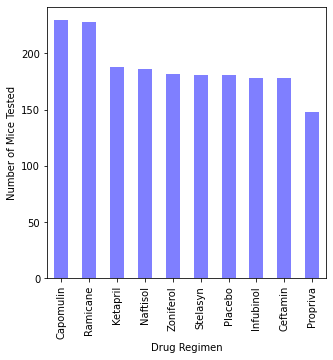

In [4763]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
# Pandas df
mouse_df_plot = mouse_df_reg['Tumor Volume (mm3)'].count() 

# Pandas Plot
mouse_df_plot.sort_values(ascending = False).plot(kind="bar", figsize=(5, 5), color = 'blue', alpha = .5)
plt.ylabel("Number of Mice Tested")
plt.show()

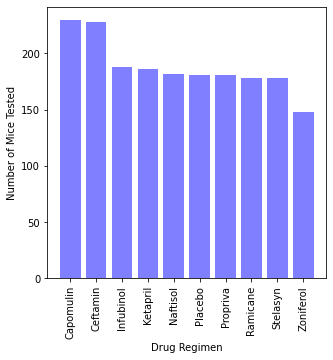

In [4764]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
# x values
x_values = np.arange(len(mouse_df_reg))
tick_locations = [x for x in x_values]
x_ticks = mouse_df_reg['Drug Regimen'].first()

# y values
y_values = sorted(mouse_df_reg['Tumor Volume (mm3)'].count(), reverse = True)

# pyplot
plt.figure(figsize = (5, 5))
plt.bar(x_values, y_values, color = 'blue', alpha = 0.5, align = "center")
plt.xticks(tick_locations, x_ticks, rotation = "vertical")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Mice Tested")
plt.show()

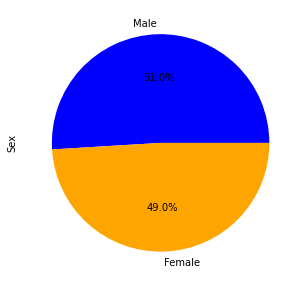

In [4765]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
# Group by Sex
mouse_df_sex = mouse_df.groupby(["Sex"])

# Count by Sex
count_sex = mouse_df_sex["Sex"].count()
count_sex

# Pandas Plot
sex_pie = count_sex.sort_values(ascending = False).plot(kind="pie", y = 'Sex', figsize=(5, 5), 
                                                        colors = ['blue', 'orange'], autopct="%1.1f%%") # Change bg color ?????

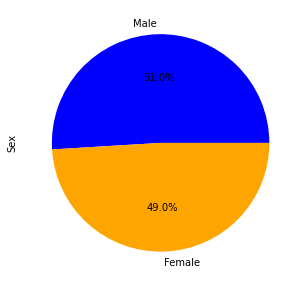

In [4766]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
# y values
sex_counts = sorted(mouse_df_sex['Sex'].count(), reverse = True)

# y labels
label_sex = sorted(mouse_df_sex['Sex'].first(), reverse = True)

# pyplot
plt.figure(figsize = (5, 5))
plt.pie(sex_counts, colors = ['blue', 'orange'], autopct="%1.1f%%", labels = label_sex)
plt.ylabel('Sex')
plt.show()

## Quartiles, Outliers and Boxplots

In [4767]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Filter for Capomulin, Ramicane, Infubinol, and Ceftamin
four_reg_df = mouse_df.loc[mouse_df['Drug Regimen'].isin(['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']), :]
four_reg_df

# Start by getting the last (greatest) timepoint for each mouse
# Group by mouse
mouse_group = four_reg_df.groupby('Mouse ID')

# Last timepoint per mouse
last_time = mouse_group['Timepoint'].max()

# Merge this group df with the original dataframe (to get the tumor volume at the last timepoint)
four_reg_df_new = pd.merge(four_reg_df, last_time, on = "Mouse ID")
four_reg_df_new = four_reg_df_new.rename(columns={"Timepoint_x":"Timepoint", "Timepoint_y":"Last Timepoint"})

# Filter for tumor volume at last timepoint
four_reg_df_last = four_reg_df_new.loc[four_reg_df_new['Timepoint'] == four_reg_df_new['Last Timepoint'], :]
four_reg_df_last

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g),Last Timepoint
9,b128,45,38.982878,2,Capomulin,Female,9,22,45
11,c326,5,36.321346,0,Infubinol,Female,18,25,5
21,c139,45,72.226731,2,Infubinol,Male,11,28,45
23,v339,5,46.250112,0,Infubinol,Male,20,26,5
30,a577,30,57.031862,2,Infubinol,Female,6,25,30
...,...,...,...,...,...,...,...,...,...
778,t565,45,34.455298,0,Capomulin,Female,20,17,45
788,i557,45,47.685963,1,Capomulin,Female,1,24,45
798,m957,45,33.329098,1,Capomulin,Female,3,19,45
803,f966,20,30.485985,0,Capomulin,Male,16,17,20


In [4768]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Calculate Q1
lowerq = [four_reg_df_last.loc[four_reg_df_last['Drug Regimen'] == drug]['Tumor Volume (mm3)'].quantile(.25) 
            for drug in treatments]

# Calculate Q3
upperq = [four_reg_df_last.loc[four_reg_df_last['Drug Regimen'] == drug]['Tumor Volume (mm3)'].quantile(.75) 
            for drug in treatments]

# Temporary data frame with Q1, Q3, IQR, and 1.5*IQR for each treatment
temp = pd.DataFrame({'Drug Regimen':treatments,
                    'Lower q': lowerq,
                    'Upper q': upperq})

temp['IQR'] = temp['Upper q'] - temp['Lower q']
temp['IQR x 1.5'] = 1.5 * (temp['Upper q'] - temp['Lower q'])

# Merge temporary data frame with original data frame and add boolean variables to detect outliers 
four_reg_df_last = pd.merge(four_reg_df_last, temp, on = "Drug Regimen")
four_reg_df_last["Lo Outlier"] = four_reg_df_last["Tumor Volume (mm3)"] < (four_reg_df_last["Lower q"] - four_reg_df_last["IQR x 1.5"])
four_reg_df_last["Hi Outlier"] = four_reg_df_last["Tumor Volume (mm3)"] > (four_reg_df_last["Upper q"] + four_reg_df_last["IQR x 1.5"])

# For loop to list outliers by treatment
for drug in treatments:
    print(drug + "'s potential outliers: " + str(four_reg_df_last.loc[(four_reg_df_last['Drug Regimen'] == drug) &
                            (four_reg_df_last['Lo Outlier'] == True) | (four_reg_df_last['Hi Outlier'] == True)]['Tumor Volume (mm3)']))
    

Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers: 25    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


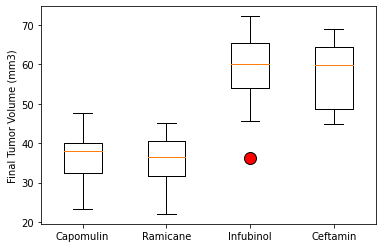

In [4769]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
treat1 = four_reg_df_last.loc[four_reg_df_last['Drug Regimen'] == "Capomulin"]['Tumor Volume (mm3)']
treat2 = four_reg_df_last.loc[four_reg_df_last['Drug Regimen'] == "Ramicane"]['Tumor Volume (mm3)']
treat3 = four_reg_df_last.loc[four_reg_df_last['Drug Regimen'] == "Infubinol"]['Tumor Volume (mm3)']
treat4 = four_reg_df_last.loc[four_reg_df_last['Drug Regimen'] == "Ceftamin"]['Tumor Volume (mm3)']

volumes = [treat1, treat2, treat3, treat4]

fig1, ax1 = plt.subplots()
ax1.set_ylabel('Final Tumor Volume (mm3)')
ax1.boxplot(volumes, flierprops={'marker': 'o', 'markersize': 12, 'markerfacecolor': 'red'})
ax1.set_xticklabels(treatments)
plt.show()

## Line and Scatter Plots

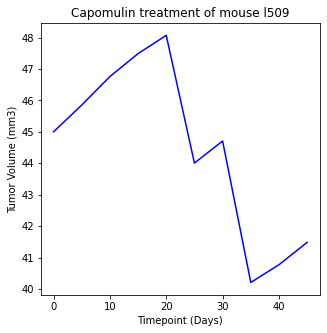

In [4770]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
# Data filtered for 'Capomulin'
mouse_df_cap = mouse_df.loc[(mouse_df['Drug Regimen'] == "Capomulin") & (mouse_df['Mouse ID'] == "l509")]
mouse_df_cap

# x values
x_vals = mouse_df_cap['Timepoint']

# y values
y_vals = mouse_df_cap['Tumor Volume (mm3)']

# Line plot
plt.figure(figsize = (5, 5))
plt.plot(x_vals, y_vals, color='blue')
plt.title('Capomulin treatment of mouse l509')
plt.xlabel("Timepoint (Days)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

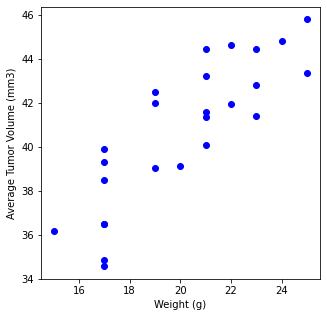

In [4771]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
# Data filtered for 'Capomulin'
mouse_df_cap2 = mouse_df.loc[mouse_df['Drug Regimen'] == "Capomulin"]
mouse_df_wgt = mouse_df_cap2.groupby(['Mouse ID'])

# x values
x_vals2 = mouse_df_wgt['Weight (g)'].first()

# y values
y_vals2 = mouse_df_wgt['Tumor Volume (mm3)'].mean()

# Scatter plot
plt.figure(figsize = (5, 5))
scat_plot = plt.scatter(x_vals2, y_vals2, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The correlation between mouse weight and the average tumor volume is 0.84


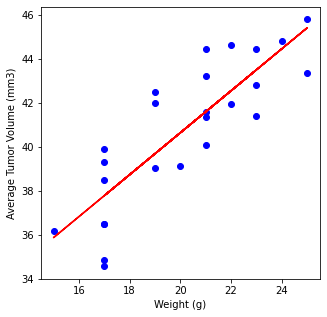

In [4772]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

# Get metrics for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_vals2, y_vals2)
regress_values = x_vals2 * slope + intercept

# print correlation coefficient
print(f"The correlation between mouse weight and the average tumor volume is {round(rvalue,2)}")

# Scatter plot with best fit line
plt.figure(figsize = (5, 5))
scat_plot2 = plt.scatter(x_vals2, y_vals2, marker="o", facecolors="blue", edgecolors="blue")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.plot(x_vals2, regress_values, "r-")
plt.show()
